# Forecast with Amazon SageMaker DeepAR 1 (Speed-violation Prediction)

This notebook shows time series forecasting using the Amazon SageMaker DeepAR algorithm by analyzing city of Chicago’s Speed Camera Violation dataset. The data is provided by Chicago Data Portal 

The dataset contains multiple camera locations. Each daily violations for a camera can be considered a separate time series. Amazon SageMaker’s DeepAR algorithm can be used to train a model for multiple streets simultaneously

For a detailed input/output interface or best practices, please refer to AWS Sagemeaker Doc [Link](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput)

In [1]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import boto3 
import csv
import io
import re
import s3fs


import sagemaker                                 
from sagemaker.predictor import csv_serializer 
from sagemaker.predictor import json_deserializer
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

### 1. Preparation (Specifying Sagemaker roles)

In [103]:
sess   = sagemaker.Session()
bucket = sess.default_bucket()                     
prefix = 'sagemaker/speed-DeepAR'
region = boto3.Session().region_name
role = '##################################' # pass your IAM role name

print('Sagemaker session :', sess)
print('S3 bucket :', bucket)
print('Prefix :', prefix)
print('Region selected :', region)
print('IAM role :', role)

Sagemaker session : <sagemaker.session.Session object at 0x0000025C329B45C8>
S3 bucket : sagemaker-us-west-2-570447867175
Prefix : sagemaker/speed-DeepAR
Region selected : us-west-2
IAM role : ##################################


### 2. Load Data

Dataset can be directly donwloaded from the city of Chicago data portal [Link](https://data.cityofchicago.org/Transportation/Speed-Camera-Violations/hhkd-xvj4) 

In [3]:
path = 'C:\\Users\\bokhy\\Desktop\\Python\\github\\amazon-sagemaker\\data'  # Set path
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page

In [4]:
df = pd.read_csv(os.path.join(path, 'Speed_Camera_Violations.csv'), encoding='utf-8')
df[['ADDRESS', 'VIOLATION DATE', 'VIOLATIONS']][0:10]

,ADDRESS,VIOLATION DATE,VIOLATIONS
0,1111 N HUMBOLDT,04/10/2015,67
1,1111 N HUMBOLDT,04/25/2015,71
2,1111 N HUMBOLDT,04/14/2015,38
3,1111 N HUMBOLDT,04/16/2015,55
4,1111 N HUMBOLDT,04/24/2015,54
5,5520 S WESTERN,04/26/2015,35
6,5520 S WESTERN,08/07/2014,42
7,5529 S WESTERN,08/07/2014,21
8,5529 S WESTERN,07/07/2014,14
9,5520 S WESTERN,08/04/2014,26


In [5]:
datafile = 'Speed_Camera_Violations.csv'
speeding_violation_data_path = '{}/{}/{}.csv'.format(bucket, prefix, datafile)
s3_output_path = '{}/{}/output'.format(bucket, prefix)
train_data_path = '{}/{}/train/train.json'.format(bucket, prefix)
test_data_path = '{}/{}/test/test.json'.format(bucket, prefix)

print('speeding_violation_data_path :', speeding_violation_data_path)
print('s3_output_path :', s3_output_path)
print('train_data_path :', train_data_path)
print('test_data_path :', test_data_path)

speeding_violation_data_path : sagemaker-us-west-2-570447867175/sagemaker/speed-DeepAR/Speed_Camera_Violations.csv.csv
s3_output_path : sagemaker-us-west-2-570447867175/sagemaker/speed-DeepAR/output
train_data_path : sagemaker-us-west-2-570447867175/sagemaker/speed-DeepAR/train/train.json
test_data_path : sagemaker-us-west-2-570447867175/sagemaker/speed-DeepAR/test/test.json


### 3. Data Pre-processing

We should convert the data into array, and use 0 for the violation count when date is not available. Using the Matplotlib library we display each camera location as a timeseries to visualize the data

Unique Addresses 164
Minimum violation date is 2014-07-01 00:00:00, maximum violation date is 2020-06-15 00:00:00


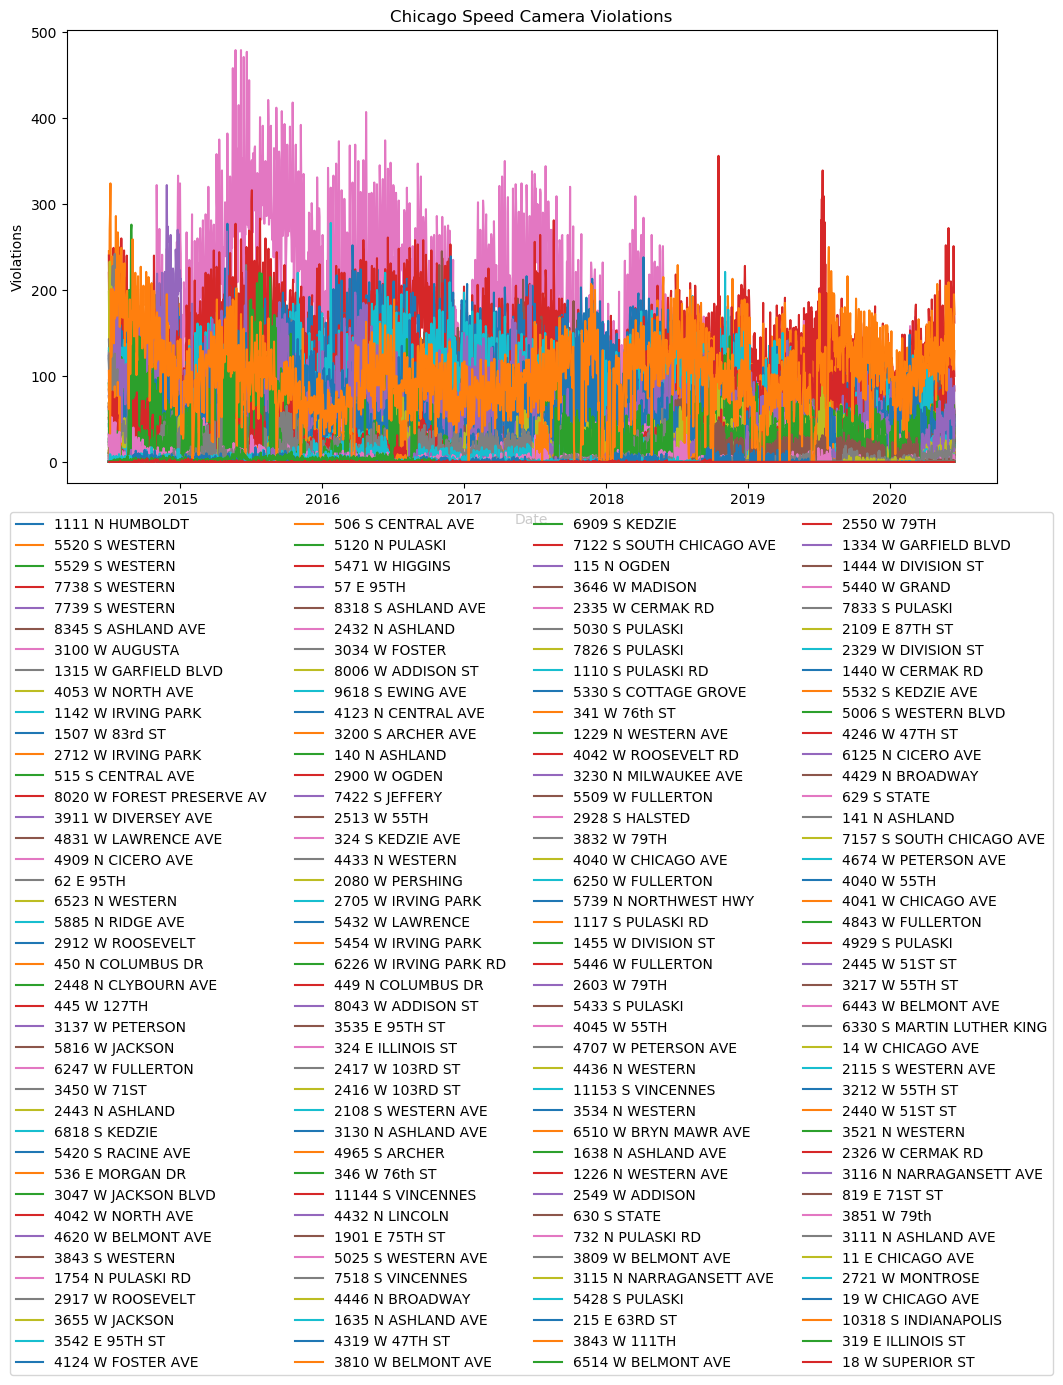

In [6]:
df['VIOLATION_DT'] = pd.to_datetime(df['VIOLATION DATE'])
df[['ADDRESS', 'VIOLATION_DT', 'VIOLATIONS']]
unique_addresses = df.ADDRESS.unique()
idx = pd.date_range(df.VIOLATION_DT.min(), df.VIOLATION_DT.max())
number_of_addresses = len(unique_addresses)
print('Unique Addresses {}'.format(number_of_addresses))
print('Minimum violation date is {}, maximum violation date is {}'.format(df.VIOLATION_DT.min(), df.VIOLATION_DT.max()))


violation_list = []
for key in unique_addresses:
    temp_df = df[['VIOLATION_DT', 'VIOLATIONS']][df.ADDRESS == key]
    temp_df.set_index(['VIOLATION_DT'], inplace=True)
    temp_df.index = pd.DatetimeIndex(temp_df.index)
    temp_df = temp_df.reindex(idx, fill_value=0)
    violation_list.append(temp_df['VIOLATIONS'])

plt.figure(figsize=(12,6), dpi=100, facecolor='w')
for key, address in enumerate(unique_addresses):
    plt.plot(violation_list[key], label=address)

plt.ylabel('Violations')
plt.xlabel('Date')
plt.title('Chicago Speed Camera Violations')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=False, ncol=4)
plt.show()

1. Define prediction length: 30 days
2. Split the data Train/Valid/Test data (We write the training and test data files in JSON format in the S3 bucket)

In [7]:
prediction_length = 30

# Split the data for training and validation/hold out
violation_list_training = []
for i in violation_list:
    violation_list_training.append((i[:-prediction_length]))

def series_to_obj(ts, cat=None):
    obj = {'start': str(ts.index[0]), 'target': list(ts)}
    if cat:
        obj['cat'] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

encoding = 'utf-8'
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(train_data_path, 'wb') as fp:
    for ts in violation_list_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(test_data_path, 'wb') as fp:
    for ts in violation_list:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

### 4. Start Training

1. Create 'Estimator' to start training job. The train_use_spot parameter indicates the use of managed spot training. The training will run at most 1 hour (3600 seconds).

2. Do Hyperparameter optimization for getting the best values. The Automatic Model Tuning job will kick of 10 parallel jobs (set by by max_parallel_jobs) to search the best hyperparameters for this dataset. The jobs will try to minimize the RMSE on the test dataset using predicted and actual values.

### Tips 
Consider increasing the *max_parallel_jobs* and *train_max_run* and *train_max_wait* parameters

In [8]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.amazon.amazon_estimator import get_image_uri


container = get_image_uri(region_name=region,
                          repo_name='forecasting-deepar')
print('Algorithm :', container)

# 1. Create 'Estimator' to start training job
deepar = sagemaker.estimator.Estimator(container,
                                       role,
                                       train_instance_count=1,
                                       train_instance_type='ml.m4.xlarge',
                                       train_use_spot_instances=True, # use spot instances
                                       train_max_run=3600, # max training time in seconds
                                       train_max_wait=3600, # seconds to wait for spot instance
                                       output_path='s3://{}/{}'.format(bucket, s3_output_path),
                                       sagemaker_session=sess)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Algorithm : 156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:1


In [9]:
deepar

In [13]:
# 2. Hyperparameter optimization
freq = 'D'
context_length = 30
deepar.set_hyperparameters(time_freq=freq,
                           context_length=str(context_length),
                           prediction_length=str(prediction_length))

hyperparameter_ranges = {'mini_batch_size': IntegerParameter(100, 400),
                         'epochs': IntegerParameter(200, 400),
                         'num_cells': IntegerParameter(30,100),
                         'likelihood': CategoricalParameter(['negative-binomial', 'student-T']),
                         'learning_rate': ContinuousParameter(0.0001, 0.1)}

objective_metric_name = 'test:RMSE'

tuner = HyperparameterTuner(deepar, #
                            objective_metric_name,  # our metric that we want to compute
                            hyperparameter_ranges,  # range defind above
                            max_jobs=10, 
                            strategy='Bayesian', # Bayesian Grid Search
                            objective_type='Minimize', # we are trying to minimize RMSE
                            max_parallel_jobs=3, # 3 parallel jobs (you might have 'ResourceLimitExceeded'. Contact AWS to expand the usage)
                            early_stopping_type='Auto')

In [14]:
tuner

In [15]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train/'.format(bucket, prefix),
                                    content_type='json')
s3_input_test = sagemaker.s3_input(s3_data='s3://{}/{}/test/'.format(bucket, prefix),
                                   content_type='json')

tuner.fit({'train': s3_input_train, 'test': s3_input_test}, 
          include_cls_metadata=False)
tuner.wait()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### 5. Deploy the model

We use the HyperParameterTuner to host the best model using a single ml.m4.xlarge instance.

In [16]:
best_tuning_job_name = tuner.best_training_job()
print('best_tuning_job_name : ', best_tuning_job_name)
endpoint_name = tuner.deploy(initial_instance_count=1,
                             endpoint_name=best_tuning_job_name,
                             instance_type='ml.m4.xlarge',
                             wait=True)

best_tuning_job_name :  forecasting-deepar-200629-2248-005-a34080d1


2020-06-30 06:53:46 Starting - Preparing the instances for training
2020-06-30 06:53:46 Downloading - Downloading input data
2020-06-30 06:53:46 Training - Training image download completed. Training in progress.
2020-06-30 06:53:46 Uploading - Uploading generated training model
2020-06-30 06:53:46 Completed - Training job completedArguments: train
[06/30/2020 06:12:53 INFO 140326393591616] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[06/30/2020 

Training seconds: 2514
Billable seconds: 887
Managed Spot Training savings: 64.7%
---------------!

### 6. Predicting and evaluating with the test set

To evaluate the model, we define a DeepARPredictor class. This class extends SageMaker's RealTimePredictor class. Implementing encode and decode functions helps us make requests using pandas.Series objects rather than raw JSON strings.

In [97]:
from datetime import timedelta

class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be 
        called before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
       
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding='utf-8', num_samples=100, quantiles=['0.1', '0.5', '0.9']):
        """Requests the prediction of for the time series listed in `ts`, each with the 
        (optional) corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: 'utf-8')
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ['0.1', '0.5', '0.9'])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+timedelta(days=1) for x in ts] 
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {'num_samples': num_samples, 'output_types': ['quantiles'], 'quantiles': quantiles}
        http_request_data = {'instances': instances, 'configuration': configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df


predictor = DeepARPredictor(endpoint=best_tuning_job_name,
                            sagemaker_session=sess,
                            content_type='application/json')

Now we can use the previously created predictor object. We will predict only the first few time series, and compare the results with the actual data we kept in the test set.

In [98]:
predictor.set_prediction_parameters(freq, prediction_length)
list_of_df = predictor.predict(violation_list_training[:5])
actual_data = violation_list[:5]

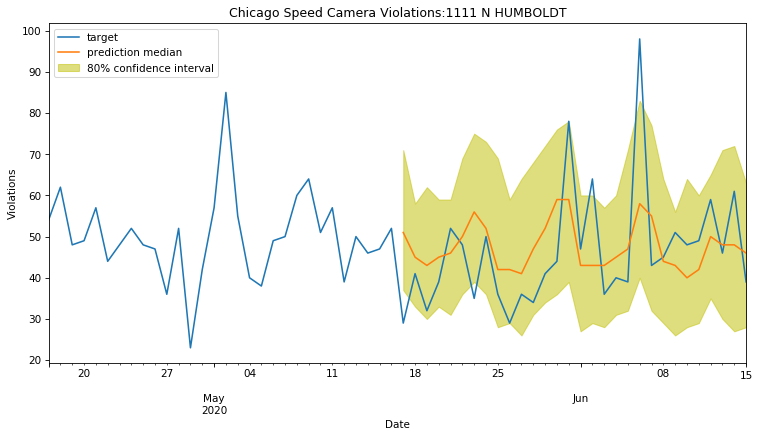

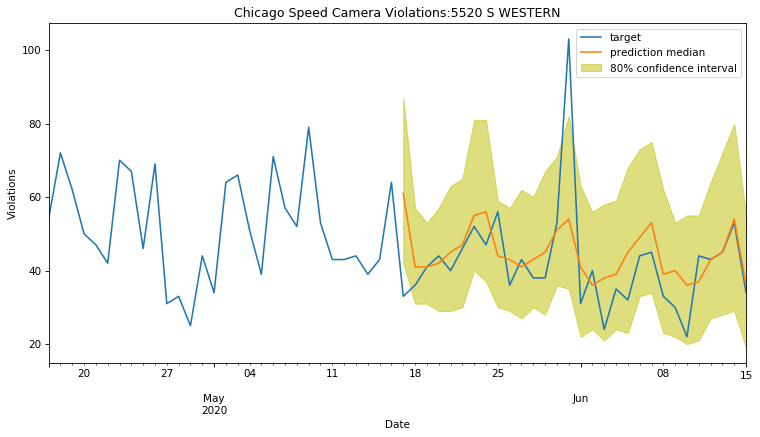

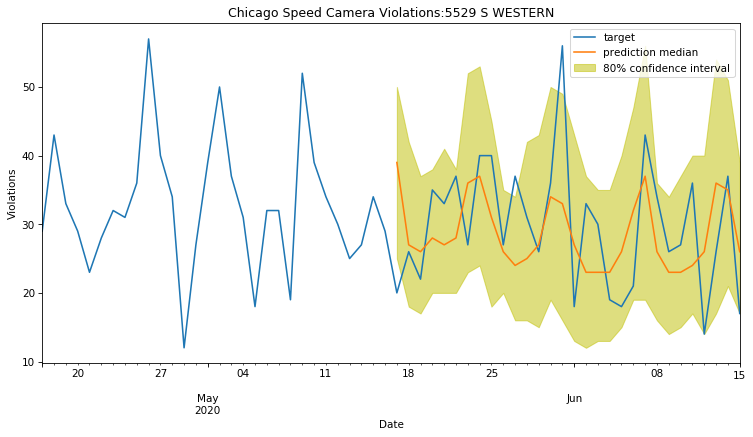

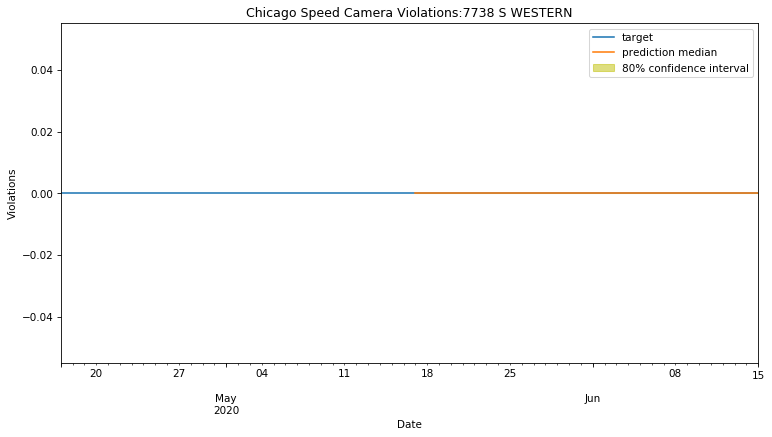

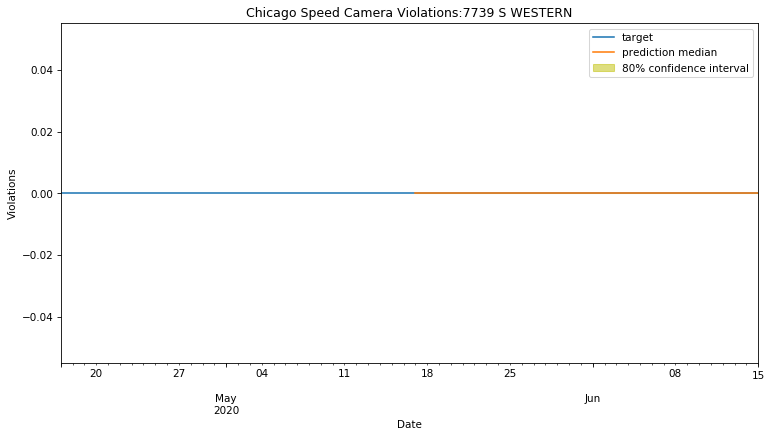

In [99]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6), dpi=75, facecolor='w')
    plt.ylabel('Violations')
    plt.xlabel('Date')
    plt.title('Chicago Speed Camera Violations:' + unique_addresses[k])
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5,label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

### 7. Close the SageMaker Instance

In [ ]:
print(endpoint_name)
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(EndpointConfigName=endpoint_name)
sess.delete_model(ModelName=endpoint_name)